In [72]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw

from matplotlib.lines import Line2D

me.mechanics_printing()

In [42]:
half = sym.Rational(1,2)

#2 Dof System
p = mf.ModelParameters.DynamicModel(2)

## Create some global parameters
p.c = mf.ModelSymbol(value = 0.15,string = 'c') # chord of wing

p.m = mf.ModelSymbol(value = 1,string = 'm')      # mass of fwt
p.m_w = mf.ModelSymbol(value = 4,string = 'm_w')  # mass of inner wing
p.s = mf.ModelSymbol(value = 1,string = 's')      # chord of fwt

p.f_0 = mf.ModelSymbol(value = 2,string = 'f_0')  # the frequency of the first bending mode 
#p.k_w = mf.ModelSymbol(value = 2,string = 'k_w')  # Stiffness of the inner wing
p.k_w = (p.f_0*2*sym.pi)**2*(p.m_w+p.m)             # Stiffness of the inner wing
p.I_xx = sym.Rational(1,12)*p.m*p.s**2*1          # FWT polar moment of inetia
p.I_xx = sym.Rational(6.5,81)*p.m*p.s**2 

p.Lambda = mf.ModelSymbol(value = np.deg2rad(10),string = 'Lambda') # flare angle

p.rho = mf.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = mf.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = mf.ModelSymbol(value = 1.2,string = 'M_thetadot')     # Unsteady Term

p.alpha_1 = mf.ModelSymbol(value = 0,string = 'alpha_1')             # FWT alpha
p.alphadot_1 = mf.ModelSymbol(value = 0,string = 'alphadot_1')       # FWT alphadot
p.clip_factor = mf.ModelSymbol(value = 100, string = 'mu') # roundedness of C_l Curve
p.c_d_max = mf.ModelSymbol(value = 1,string='C_Dmax')


## FWTD Structural Parameters
p.y_0 = sym.Symbol('y_0')
p.x_0 = sym.Symbol('x_0')


## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point

## FWT C_L 
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0')   # C_L at the root
p.a = p.a_0 - p.a_0/p.s*p.y_0                            # C_L distrobution

In [43]:
#define refernce frames
wing_root_frame = mf.HomogenousTransform().Translate(0,0,p.q[0]).R_x(-p.q[1])
wing_aero_frame = wing_root_frame.Translate(0,p.y_0,0)
wing_com_frame = wing_root_frame.Translate(0,p.s/3,0)

#Create Elemnts
M_fwt = ele.MassMatrix(p.m,I_xx = p.I_xx)
M_innerWing = ele.RigidElement.PointMass(wing_root_frame,p.m_w,True)

fwt_ele = ele.RigidElement(wing_com_frame,M_fwt,True)
spring_ele = ele.Spring(p.q[0],p.k_w)


# Create AeroForces
wing_AeroForces = ef.AeroForce_4.PerUnitSpan(p,wing_aero_frame,p.a,
                               alphadot = p.alphadot_1,
                               M_thetadot = p.M_thetadot,
                               e = 0,
                               rootAlpha = p.alpha_1,
                               alpha_zero = 0,
                            c_d_max = p.c_d_max)#.integrate((p.y_0,0,p.s))

# Setup AoA of FWT
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda,p.q[1])

## Sub in Aero Forces
wing_AeroForces = wing_AeroForces.subs({p.alpha_1:fwt_aoa,p.alphadot_1:fwt_aoa.diff(time)})

forces = [wing_AeroForces]
forces = []
segments = 5
for i in range(segments):
    seg_width = p.s/segments
    yi = seg_width/2 + i*seg_width
    forces.append(wing_AeroForces.subs({p.y_0:yi})*seg_width)
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
c_forces = ef.ExternalForce(Q)

In [44]:
sm = mf.SymbolicModel.FromElementsAndForces(p,[M_innerWing,fwt_ele,spring_ele],c_forces)

In [45]:
sm.f


⎡                                                    2⎤
⎢    2  2                              m⋅s⋅sin(q₁)⋅q₁̇ ⎥
⎢4⋅f₀ ⋅π ⋅(m + m_w)⋅q₀ + g⋅m + g⋅m_w + ───────────────⎥
⎢                                             3       ⎥
⎢                                                     ⎥
⎢                   -g⋅m⋅s⋅cos(q₁)                    ⎥
⎢                   ───────────────                   ⎥
⎣                          3                          ⎦

In [50]:
def Model_Eigen(fixed_fold = None):   
    dataset_name = 'Test'
    # Set JEC Specific parameters
    p.rho.value = 0.0885
    p.s.value = 5.8
    p.c.value = 2.16
    p.m.value = 943*0.66
    p.m_w.value = 2040
    p.f_0.value = 2
    p.Lambda.value = np.deg2rad(25) 
        
    vars_ls =[]
    vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
    vars_ls.append((p.V,np.linspace(0,900,901))) # V must be second
    vars_ls.append((p.alpha_r,np.deg2rad([0,5,10])))
    vars_ls.append((p.c_d_max,[0,1]))
    variables = [k for k,v in vars_ls]
    
    calc_fixed = True
    if fixed_fold == None:
        flutdf = rw.eigen_perm_params(p,sm,vars_ls,calc_fixed_points=True,fp = np.array([0,np.deg2rad(-30)]))
        flutdf.to_pickle(f'Test_FWT_free.pkl')
    else:
        flutdf = rw.eigen_perm_params(p,sm,vars_ls,calc_fixed_points=False,fp = np.array([0,np.deg2rad(fixed_fold)]))
        flutdf.to_pickle(f'Test_FWT_Locked_{fixed_fold}_degrees.pkl')

In [51]:
Model_Eigen()

/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [52]:
#%%time
flutdf = pd.DataFrame()
b_modes = 3
t_modes = 3

#dataset_name = 'JEC'
dataset_name = 'JEC2'
#dataset_name = 'HALE'
#dataset_name = 'TestJEC'




model_names = {0:'Locked',1:'Free',2:'Free-IWT',3:'Free-IWT,IWB',4:'Free-IWT,IWB,FRotFWT',5:'Free-IWT,IWB,FRotFWT,Lin0',6:'Free-IWT,FRotFWT,Lin0'}
model_names = {0:'Old',1:'Old,Iyy',2:'New',3:'New,Iyy'}
model_names = {0:'Locked',1:'Free',2:'Free-IWT',3:'Free-IWT,IWB',4:'Free-IWT,IWB,FRotFWT',5:'Free-IWT,IWB,FRotFWT,Drag',6:'Free-IWT,IWB,FRotFWT,Lin0',7:'Free-IWT,IWB,FRotFWT,Drag,Lin0',6:'Free-IWT,FRotFWT,Lin0'}

angles = [-30,-15,0,15,30]

ls = []
#for ang in angles:
dat = pd.read_pickle(f'Test_FWT_free.pkl')
ls.append(dat)
    
flutdf = pd.concat(ls, ignore_index=True, sort=False)

flutdf = flutdf.reset_index(drop=True)
flutdf['Damping [%]'] = flutdf['Damping']*-100
#flutdf['FWT Mass [%]'] = pd.Categorical(flutdf['delta_m']*100)
flutdf['Coast Angle [Deg]'] = np.rad2deg([i[-1] for i in flutdf['q']])
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))
#flutdf['Model'] = pd.Categorical(flutdf['Model'])
#flutdf['Config'] = pd.Categorical(flutdf['Config'])
flutdf['Mode'] = pd.Categorical(flutdf['Mode'])
flutdf['Stable'] = pd.Categorical(flutdf['Stable'])
flutdf['C_D max'] = pd.Categorical(flutdf['C_Dmax'])

#flutdf['c_dmax'] = pd.Categorical(flutdf['c_dmax'])
#flutdf['FWT Ratio [%]'] = pd.Categorical(flutdf['sigma']*100)
#flutdf['D/L'] = pd.Categorical(flutdf['sigma_DL'])

In [53]:
def iterable(obj):
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True
    
def SeriesFilter(series,var):
    if var is None:
        return series == series
    elif iterable(var):
        return series.isin(var)
    else:
        return series == var

def GetReducedDataSet(flutdf,model_num,Flare=25,AoA=0,ratio_FWT=20,FWT_mass = 100,c_dmax = 0,Vmin = 1,Vmax = 140,Modes=None,Stable=None):
    data = flutdf.copy()
    #data = data[SeriesFilter(data['Model'],model_num)]
    data = data[SeriesFilter(data['Flare Angle [Deg]'],Flare)]
    data = data[SeriesFilter(data['AoA [Deg]'],AoA)]
    #data = data[SeriesFilter(data['FWT Mass [%]'],FWT_mass)]
    data = data[SeriesFilter(data['Mode'],Modes)]
    data = data[SeriesFilter(data['Stable'],Stable)]
    #data = data[data['V']<=Vmax]
    #data = data[data['V']>=Vmin]
    
    #data = data[SeriesFilter(data['FWT Ratio [%]'],ratio_FWT)]
    #data = data[SeriesFilter(data['c_dmax'],c_dmax)]
    return data

In [67]:
def PlotLines(data,x,y,Modes,hue,ax,style='-',sigma=5,legend=True):
    unique_vars = np.unique(data[hue])
    for i in Modes:
        ax.set_prop_cycle(None)
        dat = data[data['Mode']==i]      
        for j in unique_vars:
            dat_test = dat[dat[hue]==j]
            yi = dat_test[y].to_numpy()            
            #clean up jumps in data
            ind = []
            for k in range(2,len(yi)):
                delta_1 = np.abs(yi[k]-yi[k-1])
                delta_2 = np.abs(yi[k-2]-yi[k-1])       
                if (delta_2*sigma <delta_1):
                    ind.append(k-1)
            for index in ind:
                yi[index] = np.NaN
            
            v = dat_test[x].to_numpy()
            for k in range(2,len(v)):
                if v[k]<v[k-1]:
                    v[k-1] = np.NaN 
                elif v[k]-v[k-1]>2:
                    v[k-1] = np.NaN 
            ax.plot(v,yi,style)
    if legend:
        ax.legend(np.round(unique_vars),title=hue)
    
            
            
def CoastDeltaPlot(data,hue, ax,style='-',Delta = True):# testNums,ax,Flare=25,AoA=0,FWT_ratio = 20,FWT_mass = 100,Vmax=140,Delta = True):
    # plot Coast Angle Changes
    dataMode0 =data[data['Mode']==0]
    unique_vars = np.unique(data[hue])
    
    coast_data = []
    
    for i in unique_vars:
        a = data[data[hue]==i]['Coast Angle [Deg]'].to_numpy()
        v = data[data[hue]==i]['V'].to_numpy()
        for i in range(1,len(v)):
            if v[i]<v[i-1]:
                v[i-1] = np.NaN
        coast_data.append((v,a))
    
    for v,a in coast_data:
        ax.plot(v,a,style)
    ax.set_ylabel('Coast Angle [Deg]')
    ax.set_xlabel('Velocity [m/s]')
    if Delta:
        vs = np.linspace(0,max([np.max(v) for v,a in coast_data]),100)   #np.max(v_1),100)
        a_interp = [np.interp(vs,v,a) for v,a in coast_data]
        delta = a_interp[0] - a_interp[1]
        ax2 = ax.twinx()
        ax2.set_ylabel('Delta Coast Angle [Deg]',color='r')
        ax2.plot(vs,delta,'r--')
        ax2.tick_params(axis='y', labelcolor='r')

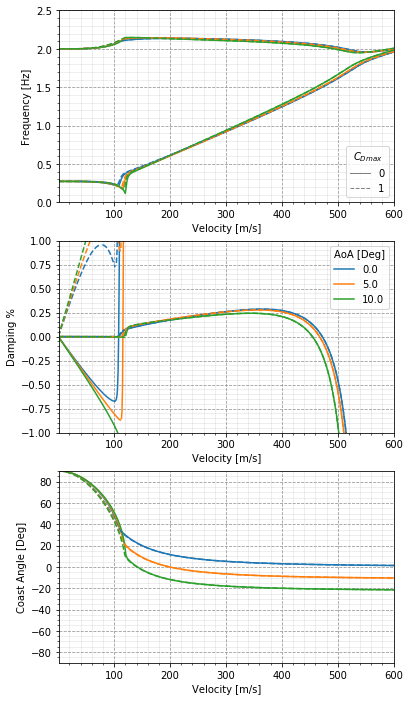

In [74]:
fig, axes = plt.subplots(3,1,figsize=(6,12))    
hue = 'AoA [Deg]'
Tests = [5]
data = GetReducedDataSet(flutdf,Tests,Flare = 25,AoA = [0,5,10],Modes=[0,1],Stable=None)
data['Coast Angle [Deg]'] = pd.Categorical(data['Coast Angle [Deg]'])

PlotLines(data[data['C_D max']==0],x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Frequency',ax = axes[0],legend=False)
PlotLines(data[data['C_D max']==0],x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Damping [%]',ax = axes[1])

PlotLines(data[data['C_D max']==1],x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Frequency',style='--',ax = axes[0],legend=False)
PlotLines(data[data['C_D max']==1],x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Damping [%]',style='--',ax = axes[1],legend=False)



#PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Frequency',ax = axes[0],legend=False)
#PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Damping [%]',ax = axes[1])
CoastDeltaPlot(data[data['C_D max']==0],hue, axes[2],Delta = False)
axes[2].set_prop_cycle(None)
CoastDeltaPlot(data[data['C_D max']==1],hue, axes[2],style = '--',Delta = False)
#print(np.unique(data['c_dmax']))
for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,40))
   

styles = ['-','--']
lines = [Line2D([0], [0], color='grey', linewidth=1, linestyle=c) for c in styles]
labels = ['0','1']
axes[0].legend(lines, labels,title='$C_{Dmax}$')

axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_ylabel('Damping %')
axes[0].set_xlabel('Velocity [m/s]')
axes[1].set_xlabel('Velocity [m/s]')

axes[0].set(xlim=(1,data['V'].max()-300))
axes[1].set(xlim=(1,data['V'].max()-300))
axes[2].set(xlim=(1,data['V'].max()-300))

axes[0].set(ylim=(0,2.5))
axes[1].set(ylim=(-1,1))    
axes[2].set(ylim=(-90,90))  

In [78]:
ds = [0,1]
cs = data['AoA [Deg]'].unique()

dat = data[data['Damping [%]']<-0.001]

dat = dat[dat['V']>200]

res =[]
for i in ds:
    dat_temp = dat[dat['C_D max']==i]
    for c in cs: 
        v_f = dat_temp[dat_temp['AoA [Deg]']==c]['V'].min()
        res.append([i,round(c),v_f])
res